## Import Libraries

In [26]:
import pandas as pd
import numpy as np 
from tqdm import tqdm
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers , models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16 , ResNet50
import matplotlib.pyplot as plt

In [56]:
# Image Params
folder_name = 'ExDark_Converted' # Location Folder
height = 256
width = 256
channels  = 3
format = 'rgb' # Image Format

### Create train dataset

In [57]:
df = pd.DataFrame(data= None , columns= ['label' , 'filename'])
dataset_path = os.getcwd().replace('notebook' , '') + folder_name
count = 0
for folder in [i for i in os.listdir(dataset_path) if i not in ['.DS_Store' , 'label.csv']]:
    for i , file in enumerate(os.listdir(dataset_path + '/' + folder)):
            if file.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
                  df.loc[count + i] = [folder, file]
            count += len(os.listdir(dataset_path + '/' + folder))
df.to_csv(os.getcwd().replace('notebook' , '') + folder_name + '/' + 'label.csv')

## Pre Processing

In [58]:
label_df_path = os.getcwd().replace('notebook' , '') + folder_name + '/' + 'label.csv' 
df = pd.read_csv(label_df_path , index_col=0)

# One Hot Encode genre file
df_encoded = pd.get_dummies(df['label'], columns=['label'])

y = df_encoded.values

### Metric Visualisation

In [59]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['categorical_accuracy'])
  plt.plot(epochRange,history.history['val_categorical_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()

## Modelling

### VGG16

#### Image Processing

In [31]:
from tensorflow.keras.applications.vgg16 import preprocess_input

x = []
for i in tqdm(range(len(df))):
    label = df['label'].iloc[i]
    filename = df['filename'].iloc[i]
    filepath = os.path.join(os.getcwd().replace('notebook', ''), folder_name, label, filename)
    img = image.load_img(filepath, target_size=(height, width) , color_mode = format)
    
    # Convert to array and add batch dimension
    img_array = image.img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0)

    # Apply VGG-specific preprocessing (RGB → BGR + mean subtraction)
    img_preprocessed = preprocess_input(img_array)
    x.append(img)
x = np.array(x)

x_train , x_test , y_train , y_test = train_test_split(x , y , test_size= 0.2)

100%|██████████| 594/594 [00:00<00:00, 1063.73it/s]


### Tranfer Learning weights freezed

In [32]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, channels))
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(5, activation='softmax')
])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4096)           │   134,221,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │        20,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,738,309 (632.24 MB)

 Trainable params: 151,023,621 (576.11 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])

In [34]:
est = model.fit(x_train,y_train , epochs=20 , batch_size=32 , validation_data=(x_test,y_test))

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - categorical_accuracy: 0.2869 - loss: 45.8114 - val_categorical_accuracy: 0.4958 - val_loss: 10.3521
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 91s 6s/step - categorical_accuracy: 0.8449 - loss: 2.4210 - val_categorical_accuracy: 0.6387 - val_loss: 4.8118
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 94s 6s/step - categorical_accuracy: 0.9776 - loss: 0.1840 - val_categorical_accuracy: 0.6807 - val_loss: 3.0201
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 95s 6s/step - categorical_accuracy: 0.9952 - loss: 0.0344 - val_categorical_accuracy: 0.6807 - val_loss: 3.7822
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 91s 6s/step - categorical_accuracy: 1.0000 - loss: 4.7795e-04 - val_categorical_accuracy: 0.7059 - val_loss: 3.2798
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 90s 6s/step - categorical_accuracy: 1.0000 - loss: 1.6542e-05 - val_categorical_accuracy: 0.7311 - val_loss: 3.2025
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 90s 6s/step - categorical_accuracy: 1.0000 - loss: 1

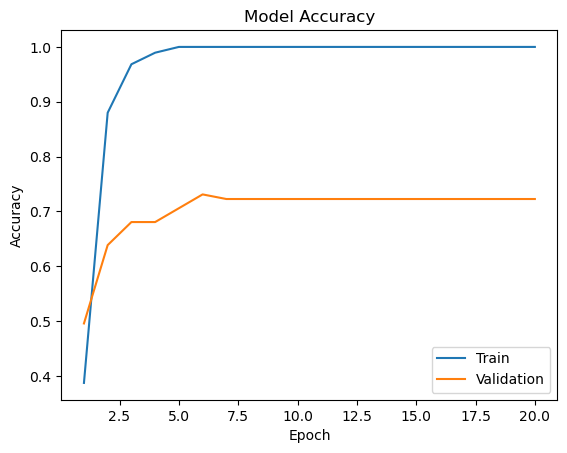

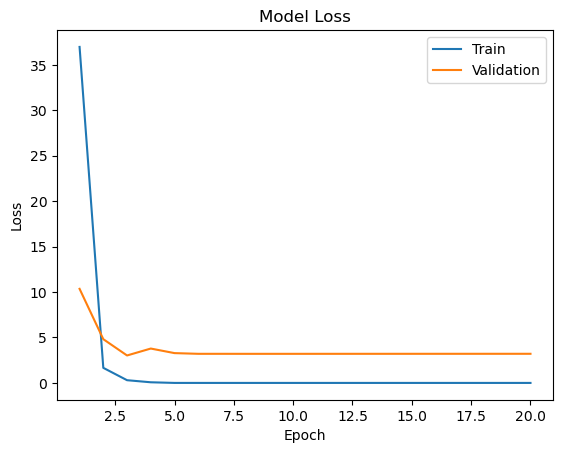

In [35]:
plotLearningCurve(est,20)

### ResNet50

#### Image Processing

In [60]:
from tensorflow.keras.applications.resnet50 import preprocess_input

x = []
for i in tqdm(range(len(df))):
    label = df['label'].iloc[i]
    filename = df['filename'].iloc[i]
    filepath = os.path.join(os.getcwd().replace('notebook', ''), folder_name, label, filename)
    img = image.load_img(filepath, target_size=(height, width) , color_mode = format)
    
    # Convert to array and add batch dimension
    img_array = image.img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0)

    # Apply VGG-specific preprocessing (RGB → BGR + mean subtraction)
    img_preprocessed = preprocess_input(img_array)
    x.append(img)
x = np.array(x)

x_train , x_test , y_train , y_test = train_test_split(x , y , test_size= 0.2)

100%|██████████| 594/594 [00:00<00:00, 980.75it/s] 


In [61]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, channels))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,691,013 (98.00 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [62]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])

In [63]:
est = model.fit(x_train,y_train , epochs=50 , batch_size=32 , validation_data=(x_test,y_test))

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 972ms/step - categorical_accuracy: 0.4095 - loss: 3.2901 - val_categorical_accuracy: 0.6975 - val_loss: 0.9070
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 881ms/step - categorical_accuracy: 0.7832 - loss: 0.5672 - val_categorical_accuracy: 0.7311 - val_loss: 0.8162
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 883ms/step - categorical_accuracy: 0.9344 - loss: 0.2254 - val_categorical_accuracy: 0.7815 - val_loss: 0.6201
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 881ms/step - categorical_accuracy: 0.9777 - loss: 0.1175 - val_categorical_accuracy: 0.8067 - val_loss: 0.6618
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 884ms/step - categorical_accuracy: 0.9944 - loss: 0.0575 - val_categorical_accuracy: 0.7815 - val_loss: 0.6476
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 882ms/step - categorical_accuracy: 0.9953 - loss: 0.0380 - val_categorical_accuracy: 0.7815 - val_loss: 0.6544
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 887ms/step - categorical_accuracy: 1.000

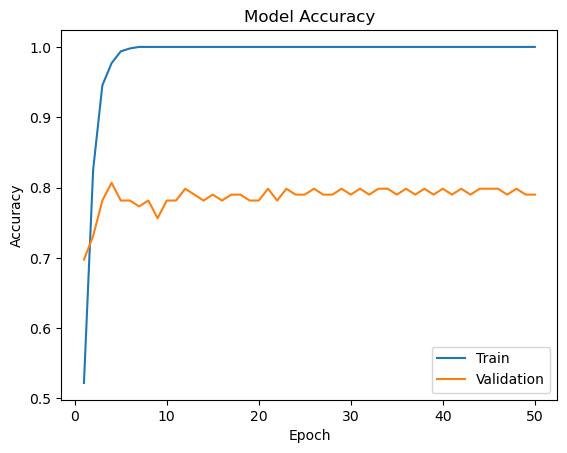

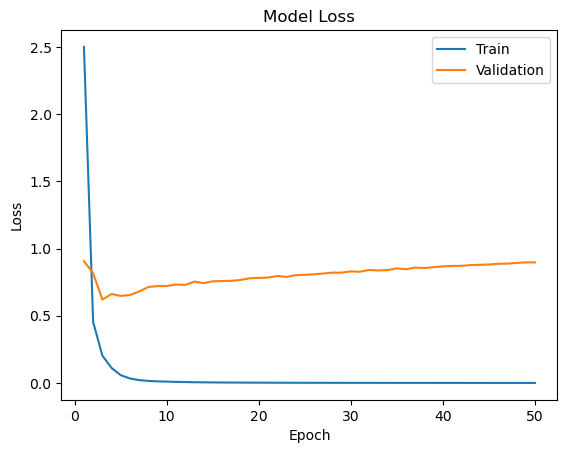

In [64]:
plotLearningCurve(est,50)